# Assignment 4
This assignment consists of 9 exercises (2 of which are bonus) divided over three notebooks. Each exercise will come with some tests that are used to verify whether your code is correct. If you pass these tests then you are rewarded *full points*; if your code fails then you will get *no points*. Make sure to **read the rules** before you start the assignment.

## Rules
For this assignment the following rules apply:

**General**
 * The assignment should be completed with the same **groups of three** as the previous assignment
 * Any kind of intergroup discussion will be considered fraud and both the parties will be punished.
 * All code must be written intra group. All external help, with the exception of Python/library documentation and the lecture slides, will be considered fraud.
 * Do not use libraries that implement the assignment for you.

**Grading**
 * If a test cell runs without error (warnings are allowed) then you receive full points.
 * If a test cell throws an error for any reason then you receive 0 points.
  * If a cell takes more than five minutes to complete then this is considered an error.
 * If your code fails a test for *any reason* then you receive 0 points for that exercise.
 * Your grade is computed as $\frac{\text{points}}{\text{max_points}} * 9 + 1$ and will be rounded to the closest 0.5 point.
 * Bonus points (if applicable) can be used to compensate lost points. You cannot get a grade higher than a 10.
 * Submit your code to Brightspace as a zip file containing only the notebook (`*.ipynb`) files.
 * **Do not rename the notebook files**

**Late Submissions**
 * Late submissions must be submitted *as soon as possible* to the "Assignment 4 - Late Submissions" assignment on Brightspace.
 * The following penalty will be applied: $\text{adjusted grade} = \text{grade} - 1 - \lceil \frac{\text{minutes late}}{10} \rceil$

<br />
 
**Before you submit**, make sure that you are not accidentaly using any global variables. Restart the kernel (wiping all global variables) and run the code from top to bottom by clicking "Kernel" => "Restart & Run all" in the menu bar at the top.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import os
import sys
sys.path.append("../../")
import helpers

# Corner Detection
In image processing and 3D reconstruction, we often encounter the need to recognize and/or compare images. An important tool for implementing these operations are image features. An image feature is a small (couple of pixels) recogniziable region in the image. By finding image features we detect those parts of the image that are more likely to be unique (=potentially recognizeable). In this notebook we will cover one of such image features: Moravec corners.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
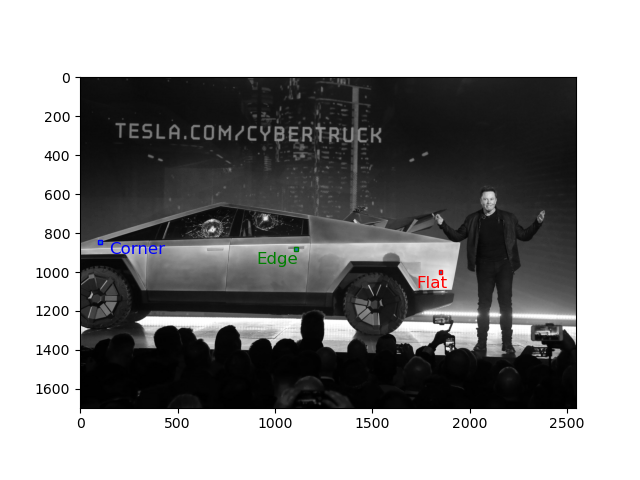

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
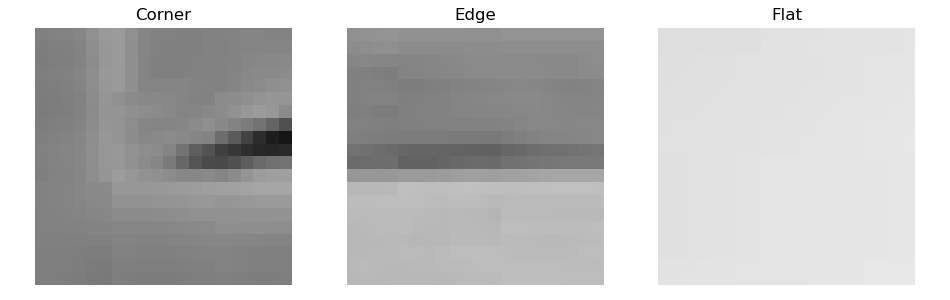

In [2]:
import matplotlib.patches as patches

def load_globals():
    global cybertruck_image, flat_cutout, edge_cutout, corner_cutout
    cybertruck_image = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week4", "corners", "cybertruck.jpg"))

    flat_cutout = cybertruck_image[990:1010, 1840:1860]
    edge_cutout = cybertruck_image[870:890, 1100:1120]
    corner_cutout = cybertruck_image[836:856, 90:110]
    
load_globals()

#helpers.show_images({ "Checkerboard": checkerboard_image, "Noisy checkerboard": noisy_checkerboard_image }, nrows=1, ncols=2)
#helpers.show_image(cybertruck_image, title="Test image")

fig, ax = plt.subplots()
ax.imshow(cybertruck_image, cmap="gray")
ax.add_patch(patches.Rectangle((1840, 990), 20, 20, linewidth = 1, edgecolor='r'))
ax.add_patch(patches.Rectangle((1100, 870), 20, 20, linewidth = 1, edgecolor='g'))
ax.add_patch(patches.Rectangle((90, 836), 20, 20, linewidth = 1, edgecolor='b'))
fig.text(0.65, 0.4, "Flat", size="large", color="r")
fig.text(0.4, 0.45, "Edge", size="large", color="g")
fig.text(0.17, 0.47, "Corner", size="large", color="b")
#fig.imshow()

helpers.show_images({ "Corner": corner_cutout, "Edge": edge_cutout, "Flat": flat_cutout }, nrows=1, ncols=3)

## Detecting corners
Moravec found that we can determine whether there is a corner in the window by analyzing a small region around the pixel (e.g., 9x9) that is referred to as a cutout window. He pointed out that if we would slightly shift the window in any direction and calculate the squared differences (SSD) between the original cutout and the shifted cutout, a strong change in values reflects the presence of an edge or corner. The reason is that a window containing only a uniformly colored region would not be affected by a shift and would still look the same. Consequently, the SSD will remain similar. In the case of an edge, shifting orthogonally to the edge will result in a large difference, while shifting along the edge would not. Finally a corner is rigid: the SSD will be high in whatever direction we shift the cutout window.

![moravec_shift](https://i.stack.imgur.com/k1CCY.png)

Mathematically, we can describe this calculation for a shift $\begin{pmatrix}u \\ v\end{pmatrix}$ as:

$$
E(u, v) = \sum_{x, y \in W} w(x, y)\ [I(x+u, y+v) - I(x, y)]^2
$$

Here, $I(x, y)$ is the intensity of a pixel ($x, y$) and $w(x, y)$ is a function that assigns a weight (often higher weights are used in the center of the cutout window). In the simplest case, all weights could be equal to one. We will use a Gaussian kernel (compare week 1).

### Exercise 1 (3 points)
Implement a function that computes $E(u, v)$ for the region around a location $(x,y)$. The weights are provided as a 2D array with the weight for $(x, y)$ in its center. Assume the weights are symmetric (so it does not matter in which direction you apply them). You do *not* have to handle the case where ($x, y$) are near the border of the images causing out-of-bounds accesses. Run the cell below to create a 3D visualization of the $E(u, v)$ function for different parts of the image; 

In [97]:
def E(gray_image, u, v, x, y, weights):
    weights_length = weights.shape[0]
    row, col = y, x
    E = 1
    rowbegin = row - weights_length//2
    rowend = row + weights_length//2 + 1
    colbegin = col - weights_length//2
    colend = col + weights_length//2 + 1 
#     if rowbegin+u < rows and colbegin+u < cols and rowbegin+u > 0 and colbegin+v > 0 \
#     and rowend+u < rows and colend+u < cols and rowend+u > 0 and colend+v > 0:
    I = gray_image[rowbegin:rowend,colbegin:colend]
    I1 = gray_image[rowbegin+u:rowend+u,colbegin+v:colend+v]
    E = (I1-I)
    E = E**2
    E = np.sum(weights*E)
    return E

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
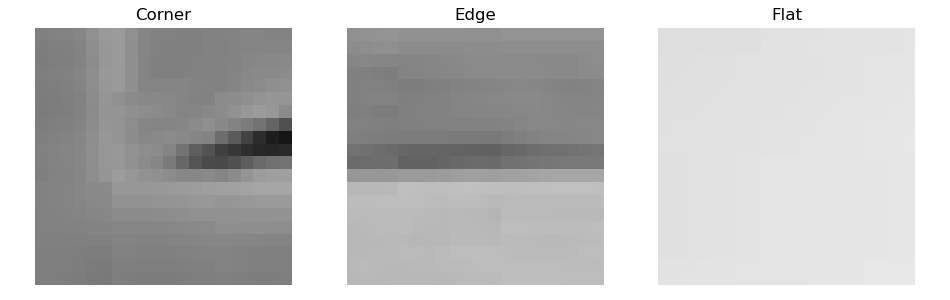

In [98]:
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def evaluate_E(gray_image, x, y, weights, uv_range):
    out = np.zeros((2*uv_range+1, 2*uv_range+1))
    for xi, u in enumerate(range(-uv_range, uv_range+1)):
        for yi, v in enumerate(range(-uv_range, uv_range+1)):
            out[yi, xi] = E(gray_image, u, v, x, y, weights)
    return out

def plot_E(gray_image, x, y):
    weights = scipy.signal.gaussian(9, 1.5).reshape(9,1)
    weights = weights @ weights.T
    z = evaluate_E(gray_image, x, y, weights, 5)
    
    uv_range = 5
    u, v = np.meshgrid(np.arange(-uv_range, uv_range+1), np.arange(-uv_range, uv_range+1))
    return go.Surface(x=u, y=v, z=z, showscale=False)

# 3D plots with plotly
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Corner", "Edge", "Flat"),
                    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "surface"}]])
fig.add_trace(
    plot_E(cybertruck_image, 100, 846),
    row=1, col=1
)
fig.add_trace(
    plot_E(cybertruck_image, 1110, 880),
    row=1, col=2
)
fig.add_trace(
    plot_E(cybertruck_image, 1850, 1000),
    row=1, col=3
)
scene = dict(zaxis=dict(range=[0,0.2]), xaxis_title="u", yaxis_title="v")
fig.update_layout(scene1=scene, scene2=scene, scene3=scene)
fig.show()

# 2D plots (matplotlib)
helpers.show_images({
    "Corner": cybertruck_image[836:856, 90:110],
    "Edge": cybertruck_image[870:890, 1100:1120],
    "Flat": cybertruck_image[990:1010, 1840:1860]
}, nrows=1, ncols=3)

### Testing your solution of exercise 1
The three different image patches should result in three distinct 3D shapes. A corner should have a single minimum at the origin and have a high response everywhere else, an edge should result in a valley, and a flat image patch will result in a plane.

## Moravec Corner Detection
As expected, the flat surface has almost no response to any shift direction. Shifting along an edge has almost no response but shifting orthogonal to it triggers a large response. Finally, in the case of a corner $E(u, v)$ is high for any direction that we try to move the window in.

There are various ways of measuring "cornerness" from this metric $E(u, v)$. To determine whether a pixel is a corner we need to know if shifting in any direction will dramatically increase the SSD ($E(u, v)$). One of the oldest and simplest algorithms is Moravec's Corner Detector. It tests small shifts of one pixel in all directions (horizontal, vertical and diagonal). If the lowest $E(u, v)$ value for any of these shifts is above a threshold then a pixel is considered a corner.

### Exercise 2 (3 points)
Implement a function that applies Moravec corner detection to each pixel of an image. You do not have to compute the values for the pixels that are within 5 pixels of the border to prevent out-of-bounds accesses. Check whether the lowest $E(u, v)$ for all shifts (except for (0, 0) of course) is above the threshold. Return $1$ for corner pixels and $0$ for all other pixels.

Wall time: 13.8 s


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
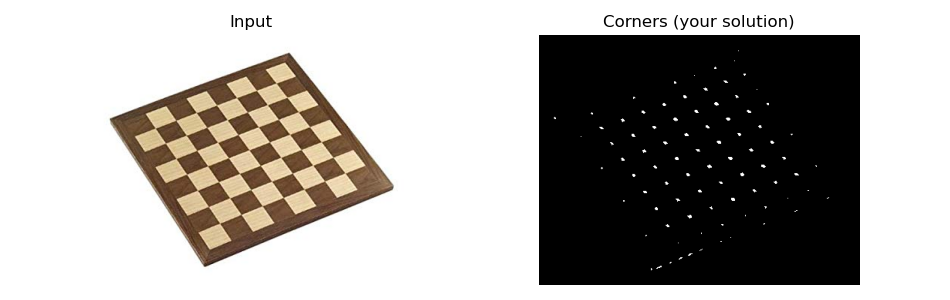

In [130]:
def compute_moravec_corners_image(gray_image, E_weights, threshold):
    rows, cols = gray_image.shape
    result = np.zeros((rows-9, cols-9))
    move = E_weights.shape[0]//2
    for row in range(5, rows-5):
        for col in range(5, cols-5):
            res = 1
            for i in range(-1,2):
                for j in range(-1,2):
                    E_intermediate = E(gray_image, j, i, col, row, E_weights)
                    if E_intermediate<threshold and (i,j) != (0,0):
                        res = 0
            result[row-4, col-4] = res
    return result

chessboard_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week4", "corners", "chessboard.jpg"))
chessboard_image = helpers.rgb2gray(chessboard_image_color)

weights = scipy.signal.gaussian(9, 1.5).reshape(9,1)
weights = weights @ weights.T

%time corners = compute_moravec_corners_image(chessboard_image, weights, 0.3)

helpers.show_images({
    "Input": chessboard_image_color,
    "Corners (your solution)": corners
}, nrows=1, ncols=2)

### Tests of exercise 2
Your solution should show a black and white image where the corners of the checkers are white (and the rest is black).

## Harris Corner Detection (NOT GRADED)
**The exercises below do not count for points and are completely optional. Only do these exercises if you have finished the graded ones.**

With the Moravec corners we looked at what happens when we shift the window by one pixel. However this may not contain enough information to accurately determine whether the window contains a corner. Furthermore, it might classify edges as corners when they are not horizontal, vertical or diagonal.

Harris Corner Detection uses a more advanced method to determine whether the shape of $E(u, v)$ describes a corner. In the end we want to reduce the shape of this function to just a single variable which indicates the "cornerness".

The first step of Harris corners is to create an approximation of the $E(u, v)$ function. We approximate $I(x+u, y+v)$ by $I(x,y) +uI_x + vI_y$ (the first order Taylor Expansion), where $I_x$ and $I_y$ are the partial derivatives of $I(x, y)$ (the image gradients). With this approximation the formula can be rewritten as:

$$
\begin{align*}
E(u, v) &= \sum_{x, y} w(x, y)\ \Bigg[I(x+u, y+u) - I(x, y)\Bigg]^2 \\
E(u, v) &\approx \sum_{x, y} w(x, y)\ \Bigg[I(x, y) + uI_x + vI_y - I(x, y)\Bigg]^2 \\
E(u, v) &\approx \sum_{x, y} w(x, y)\ \Bigg[uI_x + vI_y\Bigg]^2 \\
E(u, v) &\approx \sum_{x, y} w(x, y)\ \Bigg[\begin{pmatrix}u & v\end{pmatrix} \begin{pmatrix}I_x \\ I_y\end{pmatrix} \Bigg]^2 \\
E(u, v) &\approx \sum_{x, y} w(x, y)\ \begin{pmatrix}u & v\end{pmatrix} \begin{pmatrix}I_x \\ I_y\end{pmatrix} \begin{pmatrix}I_x & I_y\end{pmatrix} \begin{pmatrix}u \\ v\end{pmatrix} \\
E(u, v) &\approx \begin{pmatrix}u & v\end{pmatrix} \Bigg[\sum_{x, y} w(x, y)\ \begin{pmatrix}I_x \\ I_y\end{pmatrix} \begin{pmatrix}I_x & I_y\end{pmatrix} \Bigg] \begin{pmatrix}u \\ v\end{pmatrix} \\
\\
E(u,v) &\approx \begin{pmatrix}u & v\end{pmatrix} M \begin{pmatrix}u \\ v\end{pmatrix} \text{, where } M=\sum_{x,y}w(x, y) \begin{pmatrix} I_xI_x & I_xI_y \\ I_xI_y & I_yI_y \end{pmatrix}
\\
E(u,v) &\approx \begin{pmatrix}u & v\end{pmatrix} M \begin{pmatrix}u \\ v\end{pmatrix} \text{, where } M=\sum_{x,y} \begin{pmatrix} w(x, y)\ I_x I_x & w(x, y)\ I_xI_y \\ w(x, y)\ I_xI_y & w(x, y)\ I_y I_y \end{pmatrix}
\end{align*}
$$


### Exercise 3 (OPTIONAL)
Implement a function that linearly approximates $E(u, v)$ as outlined below (which is referred to as the first-order Taylor expansion for $u$ and $v$ in the range of (`-uv_range`, `+uv_range`)). Compute $I_x$ and $I_y$ by convolving the input image with the Sobel derivative kernels that we covered in week 1. You may use `scipy.signal.convolve2D(image, kernel, mode="same")` to apply a convolution. The cutout should have the following dimensions: (`window_size` x `window_size`) and the weights are uniform (they should sum up to 1).

Recall that we used the following kernels to compute the sobel derivatives:
$$
\begin{pmatrix}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\
\end{pmatrix}
\text{ and }
\begin{pmatrix}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\
\end{pmatrix}
$$

Your implementation should consist of the following steps:
* Compute the horizontal and vertical derivatives $I_x$ and $I_y$ (by convolution with Sobel kernels)
* Cut out the window of interest from $I_x$ and $I_y$
* Compute the three terms in $M$: $I_x^2$, $I_y^2$ and $I_xI_y$
* Apply the (uniform) weights
* Compute $E(u, v)$ in the range (-uv_range, +uv_range) for the given pixel

In [ ]:
def evaluate_E_taylor(gray_image, x, y, window_size, uv_range):
    half_window_size = window_size // 2
    
    out = np.zeros((2*uv_range+1, 2*uv_range+1))
    # YOUR CODE HERE
    raise NotImplementedError()
    return out
    
def plot_E_taylor(E):
    uv_range = E.shape[0] // 2
    x, y = np.meshgrid(np.arange(-uv_range, uv_range+1), np.arange(-uv_range, uv_range+1))
    return go.Surface(x=x, y=y, z=E, showscale=False)


print("YOUR SOLUTION")

E1 = evaluate_E_taylor(cybertruck_image, 100, 846, 9, 10)
E2 = evaluate_E_taylor(cybertruck_image, 1110, 880, 9, 10)
E3 = evaluate_E_taylor(cybertruck_image, 1850, 1000, 9, 10)

# 3D plots with plotly
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Corner", "Edge", "Flat"),
                    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "surface"}]])
fig.add_trace(
    plot_E_taylor(E1),
    row=1, col=1
)
fig.add_trace(
    plot_E_taylor(E2),
    row=1, col=2
)
fig.add_trace(
    plot_E_taylor(E3),
    row=1, col=3
)
scene = dict(zaxis=dict(range=[0,2]), xaxis_title="u", yaxis_title="v")
fig.update_layout(scene1=scene, scene2=scene, scene3=scene)
fig.show()



print("REFERENCE")
E1_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test1.npy"))
E2_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test2.npy"))
E3_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test3.npy"))

# 3D plots with plotly
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Corner", "Edge", "Flat"),
                    specs=[[{"type": "surface"}, {"type": "surface"}, {"type": "surface"}]])
fig.add_trace(
    plot_E_taylor(E1_reference),
    row=1, col=1
)
fig.add_trace(
    plot_E_taylor(E2_reference),
    row=1, col=2
)
fig.add_trace(
    plot_E_taylor(E3_reference),
    row=1, col=3
)
scene = dict(zaxis=dict(range=[0,2]), xaxis_title="u", yaxis_title="v")
fig.update_layout(scene1=scene, scene2=scene, scene3=scene)
fig.show()

### Tests of exercise 3
Tests whether the response function matches the reference.

In [ ]:
load_globals()

E1 = evaluate_E_taylor(cybertruck_image, 100, 846, 9, 10)
E1_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test1.npy"))
assert(helpers.SSD_per_pixel(E1, E1_reference) < 0.0001)

E2 = evaluate_E_taylor(cybertruck_image, 1110, 880, 9, 10)
E2_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test2.npy"))
assert(helpers.SSD_per_pixel(E2, E2_reference) < 0.0001)

E3 = evaluate_E_taylor(cybertruck_image, 1850, 1000, 9, 10)
E3_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "harris_taylor_test3.npy"))
assert(helpers.SSD_per_pixel(E3, E3_reference) < 0.0001)

The equation $E(u,v)=\begin{pmatrix}u & v\end{pmatrix} M \begin{pmatrix}u \\ v\end{pmatrix}$ also describes an ellipse. We can confirm that this is the case by looking at the 3D graphs above: they all have an ellipsical shape (when viewed from above). In general the equation of an ellipse can be formulated as:

$$
Q(x,y) = Ax^2 + Bxy + Cy^2 + F = 0 \\
Q(x,y) = \begin{pmatrix}x & y\end{pmatrix} \begin{pmatrix}A & B/2 \\ B/2 & C\end{pmatrix} \begin{pmatrix}x \\ y\end{pmatrix} = -F \\
Q(x,y) = \begin{pmatrix}x & y\end{pmatrix} M \begin{pmatrix}x \\ y\end{pmatrix} = -F
$$

$M$ is a matrix which describes the shape of an ellipse. This is similar to the covariance matrix that we considered in the PCA assignment. Like in last week's assignment we can compute the axis spanning the ellipse by computing the eigen vectors and eigen values. The width of the ellipse along the eigenvectors (axes) has the following correspondance to the eigenvalue: $\frac{1}{\sqrt{\lambda}}$ (where $\lambda$ is the eigen value). Thus if the width of the ellipse along the eigenvector is small then the corresponding eigenvalue will be large, and vice versa.

![eigenvalue](https://docs.opencv.org/3.4.3/harris_region.jpg)

A corner is described by a small and roughly circular ellipse where $\lambda_1 \sim \lambda_2$ (the eigenvalues are similar) and both are large. Flat regions have a very large ellipse where both eigenvalues are very small. Finally an edge is characterized by a long ellipse where one eigenvalue is much larger than the other one.

The goal now is to find a function that measures the "cornerness" based on the two eigenvalues $\lambda_1$ and $\lambda_2$. Harris found the following function to work well:
$$
\begin{align}
R &= \lambda_1\lambda_2 - k(\lambda_1 + \lambda_2)^2 \\
R &= determinant(M) - k [trace(M)]^2 \\
R &= ((I_x I_x) (I_y I_y) - (I_x I_y) (I_x I_y)) - k (I_x I_x + I_y I_y)^2
\end{align}
$$

The constant $k$ was empirically determined to be $k \in [0.04, 0.06]$

In [ ]:
import matplotlib.cm as cm

def R(lambda1, lambda2):
    return lambda1*lambda2 - 0.05*(lambda1 + lambda2)**2

l1 = l2 = np.linspace(0, 50)
L1, L2 = np.meshgrid(l1, l2)
Z = R(L1, L2)

fig, ax = plt.subplots(figsize=helpers.default_fig_size)
ax.imshow(Z, cmap=cm.coolwarm)
ax.invert_yaxis() # imshow by default reverse y-axis
ax.set_title("R($\lambda_1$, $\lambda_2$)")
ax.set_xlabel("$\lambda_1$")
ax.set_ylabel("$\lambda_2$")
plt.tight_layout()
plt.show()

### Exercise 4 (OPTIONAL)
Implement a function that computes the corner response $R$ for each pixel (thus returning a new image with the same shape as the input). Your implementation should consist of the following steps:
* Compute the horizontal and vertical derivatives $I_x$ and $I_y$ (with Sobel kernels)
* Compute the three terms in $M$: $I_x^2$, $I_y^2$ and $I_xI_y$
* Apply the weight function to those terms (using a convolution)
* Compute $R$ for each pixel

In [ ]:
def compute_harris_response(gray_image, weights, k):
    # YOUR CODE HERE
    raise NotImplementedError()

chessboard_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week4", "corners", "chessboard.jpg"))
chessboard_image = helpers.rgb2gray(chessboard_image_color)

weights = scipy.signal.gaussian(9, 0.5).reshape(9,1)
weights = weights @ weights.T

R = compute_harris_response(chessboard_image, weights, 0.01)
R_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "chessboard_harris.npy"))

helpers.show_images({
    "Input": chessboard_image_color,
    "Corners (your solution)": np.clip(R, 0.0, 1.0), # Clamp values between 0.0 and 1.0
    "Corners (reference)": np.clip(R_reference, 0.0, 1.0)
}, nrows=1, ncols=3)

### Tests of exercise 4
Tests whether the response function matches the reference.

In [ ]:
load_globals()

weights = scipy.signal.gaussian(9, 0.5).reshape(9,1)
weights = weights @ weights.T

R = compute_harris_response(chessboard_image, weights, 0.01)
R_reference = np.load(os.path.join(helpers.dataset_folder, "week4", "corners", "chessboard_harris.npy"))
assert(helpers.SSD_per_pixel(R, R_reference) < 0.0001)